# tf.gradient

In [1]:
def f(x, y):
    return x**2 + x*y + y**2

In [2]:
def f_x(x, y):
    return 2*x + y

In [3]:
def f_y(x, y):
    return x + 2*y

In [4]:
print(f(0.2, 0.3))
print(f_x(0.2, 0.3))
print(f_y(0.2, 0.3))

0.19
0.7
0.8


In [58]:
import tensorflow as tf; tf.reset_default_graph()

init_x = tf.keras.initializers.constant(0.2)
init_y = tf.keras.initializers.constant(0.3)

#float64로 하면 더 정확한 값이 나오지만, tf는 워낙 많은 값을 계산하다보니 32를 더 많이 씀.
x = tf.get_variable('x', (), tf.float32, init_x)
y = tf.get_variable('y', (), tf.float32, init_y)
f = x**2 + x*y + y**2

In [12]:
grads = tf.gradients(f, [x, y]) # list of tensors
print(grads)
print(type(grads)) # list

[<tf.Tensor 'gradients/AddN:0' shape=() dtype=float32>, <tf.Tensor 'gradients/AddN_1:0' shape=() dtype=float32>]
<class 'list'>


In [13]:
f_x = grads[0]
f_y = grads[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run([f, f_x, f_y]))

[0.19000001, 0.70000005, 0.8]


In [14]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(type(housing))
print(dir(housing))

<class 'sklearn.utils.Bunch'>
['DESCR', 'data', 'feature_names', 'target']


In [16]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [17]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [19]:
print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


In [21]:
x_data = housing.data
y_data = housing.target
print(x_data.shape, y_data.shape)

(20640, 8) (20640,)


In [22]:
import numpy as np
idx = np.arange(20640)
np.random.shuffle(idx)

#endpoint는 exclusive, startpoint는 inclusive
x_train = housing.data[idx[:15000]] 
y_train = housing.target[idx[:15000]] 
x_test = housing.data[idx[15000:]] 
y_test = housing.target[idx[15000:]] 

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 8) (15000,)
(5640, 8) (5640,)


In [34]:
#표준화? 정규화(normalize) 작업. 
#normalize를 해줌으로써 숫자도 예쁘게 나오고 돌리는 시간도 적게 걸림.
#keepdims=FALSE 이면 dimension이 안 살아있음. (8, )이런 식으로 나옴
#전체 set이 아니라 train set을 가지고 mu와 sigma를 계산
mu = np.mean(x_train, axis=0, keepdims=True)
sigma = np.std(x_train, axis=0, keepdims=True)
print(mu.shape, sigma.shape)

(1, 8) (1, 8)


In [35]:
x_train = (x_train-mu)/sigma 
x_test = (x_test-mu)/sigma

In [37]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [38]:
epoch = int(1e3) #몇 번 돌릴 건지
lr = 1e-2

In [40]:
m, n = x_train.shape #(15000, 8)이므로 m=15000, n=8 
design_matrix = np.concatenate([np.ones((m, 1)), x_train], axis=1)

#design matrix 값을 갖는 tensor
A = tf.constant(design_matrix, dtype=tf.float32, name="A")
x_train_tensor = tf.constant(x_train, dtype=tf.float32, name="x")
#뒤에서 y_train_pred는 (15000,1)로 나오는데 y_train_tensor는 (15000,)
#이 둘의 계산은 broadcast rule 적용이 안 되므로 reshape을 해준다.
y_train_tensor = tf.constant(y_train.reshape((-1, 1)), dtype=tf.float32, name="y")
AT = tf.transpose(A)

In [41]:
init_theta = tf.keras.initializers.VarianceScaling(mode='fan_avg')

#n이 필기에서 beta같은 것. 1을 더해준 것은 intercept term인 alpha같은 것.
theta = tf.get_variable("theta", [n + 1, 1], tf.float32, init_theta)
theta_w = theta[1:,:] 
theta_b = theta[0,:]

#predict 값
y_train_pred = x_train_tensor@theta_w + theta_b

In [42]:
error = y_train_pred - y_train_tensor #(15000, 1) rank 2

#reduce : rank가 줄어든다는 소리. 이 경우 rank=0이 됨. keepdims같은 것이 있으면 유지됨.
loss = tf.reduce_mean(tf.square(error), name="loss")
gradients = 2/m * (AT@error)
train = tf.assign(theta, theta - lr * gradients)

In [44]:
x = tf.placeholder(tf.float32, [None, 8])
y_pred = x@theta_w + theta_b

In [45]:
init = tf.global_variables_initializer()

In [47]:
with tf.Session() as sess:
    sess.run(init)
    loss_trace = []
    for _ in range(epoch):
        loss_run, _ = sess.run([loss, train])
        loss_trace.append(loss_run)
    feed_dict = {x: x_test}
    y_test_pred = sess.run(y_pred, feed_dict=feed_dict)

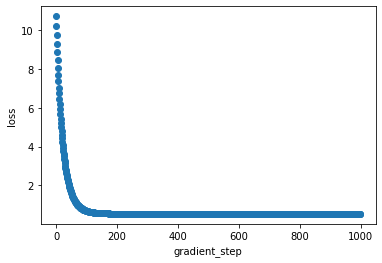

In [48]:
#계산 결과(loss가 잘 떨어지는지)를 그림으로 표현
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace, 'o')
plt.xlabel('gradient_step')
plt.ylabel('loss')
plt.show()

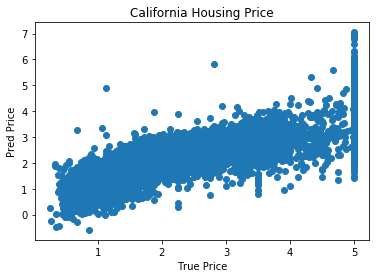

In [50]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test_pred, 'o')
plt.xlabel('True Price')
plt.ylabel('Pred Price')
plt.title('California Housing Price')
plt.show()

집 값이 높은 건 prediction이 잘 안 되고

실제 값에 비해 prediction이 낮은 것 같아!

### 2교시

In [ ]:
error = y_train_pred - y_train_tensor 
loss = tf.reduce_mean(tf.square(error), name="loss")

In [ ]:
#어떻게 해도 같은 결과가 나온다!
#즉, 수학적인 formula를 몰라도 tensorflow를 이용하면 알아서 gradient를 계산해준다!!
if 0:
    # use mathematical formula
    gradients = 2/m * (AT@error)
    train = tf.assign(theta, theta - lr *gradient)
elif 0:
    # use tf.gradients 
    gradients = tf.gradients(loss, [theta])[0] 
    train = tf.assign(theta, theta - lr *gradient)
elif 1:
    # use train optimizer 조금 더 간단!
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss)

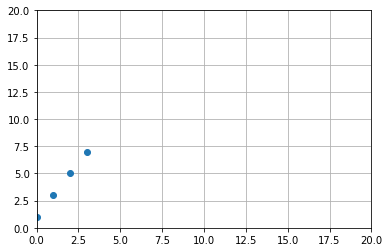

In [155]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_data = np.arange(4).astype(np.float32).reshape( (-1,1) )
y_data = 2 * x_data + 1
plt.plot(x_data.reshape((-1,)), y_data.reshape((-1,)), 'o')
plt.xlim([0,20])
plt.ylim([0,20])
plt.grid()
plt.show()

In [174]:
import tensorflow as tf; tf.reset_default_graph()

In [175]:
epoch = int(1e3)
lr = 1e-3

In [176]:
init_al = tf.keras.initializers.zeros()
init_bt = tf.keras.initializers.constant(0.1)
al = tf.get_variable("al", (), tf.float32, init_al)
bt = tf.get_variable("bt", (), tf.float32, init_bt)

In [177]:
x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])

In [178]:
y_pred = al + x * bt # (?, 1)
loss = tf.nn.l2_loss(y_pred - y) #l2 loss (12아님...)

In [179]:
if 0: #alpha, beta 모두 gradient descent 작용 (변화함)
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss)
elif 0 : #beta만 변경
    tf.add_to_collection('beta', bt)
    var_list = tf.get_collection('beta')
    print(var_list)
    print(type(var_list))
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss, var_list=var_list) #list에 있는 beta만 가지고 와서 해라!
elif 1 : #alpha만 변경
    tf.add_to_collection('alpha', al)
    var_list = tf.get_collection('alpha')
    print(var_list)
    print(type(var_list))
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss, var_list=var_list) #list에 있는 alpha만 가지고 와서 해라!

[<tf.Variable 'al:0' shape=() dtype=float32_ref>]
<class 'list'>


In [180]:
init = tf.global_variables_initializer()

In [181]:
with tf.Session() as sess:
    sess.run(init)
    loss_trace = []
    for _ in range(epoch):
        feed_dict = {x : x_data, y : y_data}
        loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
        loss_trace.append(loss_run)
    feed_dict = {x: x_data}
    y_data_pred = sess.run(y_pred, feed_dict=feed_dict)
    print(sess.run([al, bt]))

[3.7800481, 0.1]


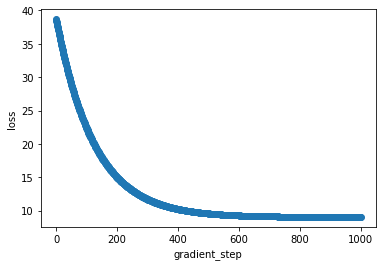

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace, 'o')
plt.xlabel('gradient_step')
plt.ylabel('loss')
plt.show()

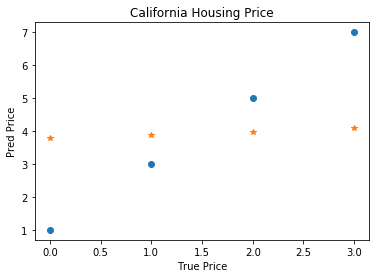

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_data.reshape((-1)), y_data.reshape((-1)), 'o')
plt.plot(x_data.reshape((-1)), y_data_pred.reshape((-1)), '*')
plt.xlabel('True Price')
plt.ylabel('Pred Price')
plt.title('California Housing Price')
plt.show()

## clipping

In [184]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1, 28*28) / 255.0
x_test = x_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [185]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        x_batch, y_batch = x[batch_idx], y[batch_idx]
        yield x_batch, y_batch

In [186]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [187]:
lr = 1e-2
epoch = 20
batch_size = 200
threshold = 1.0 #(-1,1)으로 clipping 하려는 parameter

In [188]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

x = tf.placeholder(tf.float32, shape=(None, n_inputs), name="x")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.variable_scope("dnn"):
    hidden1 = tf.layers.dense(x, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.variable_scope("loss"):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(entropy, name="loss") #loss function

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [189]:
opt = tf.train.GradientDescentOptimizer(lr)
# train = opt.minimize(loss) <- 아까는 이렇게 했었음
grads_and_vars = opt.compute_gradients(loss)

#이 부분이 없으면 그냥 기존의 gradient descent(아까 했던 것!) 
clipped_grads_and_vars = [ (tf.clip_by_value(grad, -threshold, threshold), var)
                         for grad, var in grads_and_vars] #list안의 tuple 안에 있는 애들을 각각 지정
train = opt.apply_gradients(clipped_grads_and_vars)

In [192]:
print(grads_and_vars)

[(<tf.Tensor 'gradients/dnn/hidden1/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 300) dtype=float32>, <tf.Variable 'dnn/hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>), (<tf.Tensor 'gradients/dnn/hidden1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(300,) dtype=float32>, <tf.Variable 'dnn/hidden1/bias:0' shape=(300,) dtype=float32_ref>), (<tf.Tensor 'gradients/dnn/hidden2/MatMul_grad/tuple/control_dependency_1:0' shape=(300, 50) dtype=float32>, <tf.Variable 'dnn/hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>), (<tf.Tensor 'gradients/dnn/hidden2/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>, <tf.Variable 'dnn/hidden2/bias:0' shape=(50,) dtype=float32_ref>), (<tf.Tensor 'gradients/dnn/hidden3/MatMul_grad/tuple/control_dependency_1:0' shape=(50, 50) dtype=float32>, <tf.Variable 'dnn/hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>), (<tf.Tensor 'gradients/dnn/hidden3/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>,

In [193]:
print(type(grads_and_vars))

<class 'list'>


In [195]:
print(type(grads_and_vars[0]))
print(grads_and_vars[0])

<class 'tuple'>
(<tf.Tensor 'gradients/dnn/hidden1/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 300) dtype=float32>, <tf.Variable 'dnn/hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>)


In [196]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [197]:
init = tf.global_variables_initializer()

In [198]:
with tf.Session() as sess:
    init.run()
    for i in range(epoch):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={x: x_valid, y: y_valid})
        print(i, "Validation accuracy:", accuracy_val)

0 Validation accuracy: 0.5998
1 Validation accuracy: 0.8308
2 Validation accuracy: 0.8762
3 Validation accuracy: 0.908
4 Validation accuracy: 0.9146
5 Validation accuracy: 0.9254
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9346
8 Validation accuracy: 0.9392
9 Validation accuracy: 0.9444
10 Validation accuracy: 0.945
11 Validation accuracy: 0.9488
12 Validation accuracy: 0.9498
13 Validation accuracy: 0.9504
14 Validation accuracy: 0.955
15 Validation accuracy: 0.9544
16 Validation accuracy: 0.9558
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.96
19 Validation accuracy: 0.9598


In [24]:
conda list

# packages in environment at C:\Users\sarah\Anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
absl-py                   0.8.0                    pypi_0    pypi
alabaster                 0.7.12                   py37_0  
anaconda                  2019.07                  py37_0  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.7                    py37_0  
anaconda-project          0.8.3                      py_0  
asn1crypto                0.24.0                   py37_0  
astor                     0.8.0                    pypi_0    pypi
astroid                   2.2.5                    py37_0  
astropy                   3.2.1            py37he774522_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.1.0                   py37_1  
babel                     2.7.0                      py_0  
backcall                